## Chorin's Projection

In this notebook, we will compare various preconditioner for the linear system and how it improve trainability of VQE.

### Main Algorithm

In [7]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

Lx = 1              # length of domian in x-direction
Ly = 1              # length of domian in y-direction
nx = 4              # grid size in x-direction
ny = 4              # grid size in y-direction

Re = 100            # Reynolds number
nu = 1/Re           # kinematic viscosity
rho = 1.0           # density
dt =  1             # time step size
itr = 10             # iterations
velocity = 1.0

# Create staggered grid index system
imin, jmin = 1, 1
imax = imin + nx - 1
jmax = jmin + ny - 1

# Define ghost cells for boundary conditions
x = np.zeros(jmax + 2)
y = np.zeros(jmax + 2)
x[imin: imax + 2] = np.linspace(0, Lx, nx + 1, endpoint=True)
y[jmin: jmax + 2] = np.linspace(0, Ly, ny + 1, endpoint=True)

dx = x[imin + 1] - x[imin]
dy = y[jmin + 1] - y[jmin]
dxi = 1 / dx
dyi = 1 / dy

# Define Laplacian
def Laplacian(nx, ny, dxi, dyi):
    Dx = np.diag(np.ones(nx)) * 2 - np.diag(np.ones(nx - 1), 1) - np.diag(np.ones(nx - 1), -1)
    Dx[0, 0] = 1
    Dx[-1, -1] = 1
    Ix = np.diag(np.ones(ny))
    Dy = np.diag(np.ones(ny)) * 2 - np.diag(np.ones(ny - 1), 1) - np.diag(np.ones(ny - 1), -1)
    Dy[0, 0] = 1
    Dy[-1, -1] = 1
    Iy = np.diag(np.ones(nx))
    L = np.kron(Ix, Dx) * dxi ** 2 + np.kron(Dy, Iy) * dyi ** 2
    return L

L = Laplacian(nx, ny, dxi, dyi)
L[0,:]=0
L[0,0]=1


# Variable declaration
u = np.zeros((imax + 2, jmax + 2))
v = np.zeros((imax + 2, jmax + 2))

res_hist_classical = []
for timestep in tqdm(range(itr)):
    
    # u-momentum
    us = u.copy()
    u_old = u.copy()
    I = slice(imin + 1, imax + 1)
    Ib = slice(imin, imax)
    If = slice(imin + 2, imax + 2)
    J = slice(jmin, jmax + 1)
    Jb = slice(jmin - 1, jmax)
    Jf = slice(jmin + 1, jmax + 2)

    v_here = 0.25 * (v[Ib, J] + v[Ib, Jf] + v[I, J] + v[I, Jf])
    us[I, J] = u[I, J] + dt * (
            nu * (u[Ib, J] - 2 * u[I, J] + u[If, J]) * dxi ** 2
            + nu * (u[I, Jb] - 2 * u[I, J] + u[I, Jf]) * dyi ** 2
            - v_here * (u[I, Jf] - u[I, Jb]) * 0.5 * dyi
            - u[I, J] * (u[If, J] - u[Ib, J]) * 0.5 * dxi
    )


    # v-momentum
    vs = v.copy()
    v_old = v.copy()
    I = slice(imin, imax + 1)
    Ib = slice(imin - 1, imax)
    If = slice(imin + 1, imax + 2)
    J = slice(jmin + 1, jmax + 1)
    Jb = slice(jmin, jmax)
    Jf = slice(jmin + 2, jmax + 2)

    u_here = 0.25 * (u[I, Jb] + u[I, J] + u[If, Jb] + u[If, J])
    vs[I, J] = v[I, J] + dt * (
            nu * (v[Ib, J] - 2 * v[I, J] + v[If, J]) * dxi ** 2
            + nu * (v[I, Jb] - 2 * v[I, J] + v[I, Jf]) * dyi ** 2
            - u_here * (v[If, J] - v[Ib, J]) * 0.5 * dxi
            - v[I, J] * (v[I, Jf] - v[I, Jb]) * 0.5 * dyi
    )


    # Claculate R.H.S of pressure Poisson
    Rn = -rho / dt * ((us[imin + 1: imax + 2, jmin: jmax + 1]
                       - us[imin: imax + 1, jmin: jmax + 1]) * dxi
                      + (vs[imin: imax + 1, jmin + 1: jmax + 2]
                       - vs[imin: imax + 1, jmin: jmax + 1]) * dyi)
    
    R = Rn.T.ravel()
    
    # Prepare linear system for VQE
    pv = np.linalg.solve(L, R)

    pn = pv.reshape(ny, nx).T
    p = np.zeros((imax + 1, jmax + 1))
    p[1:, 1:] = pn
    p[0, 0] = 0


    # Correct velocity
    u[imin + 1: imax + 1, jmin: jmax + 1] = us[imin + 1: imax + 1, jmin: jmax + 1] - dt / rho * (
                p[imin + 1: imax + 1, jmin: jmax + 1] - p[imin: imax, jmin: jmax + 1]) * dxi
    v[imin: imax + 1, jmin + 1: jmax + 1] = vs[imin: imax + 1, jmin + 1: jmax + 1] - dt / rho * (
                p[imin: imax + 1, jmin + 1: jmax + 1] - p[imin: imax + 1, jmin: jmax]) * dyi
    
    # Update BCs
    v[imin,:] = 0.0                   # left wall
    v[imax+1,:] = 0.0                 # right wall
    v[:, jmin-1] = -v[:, jmin]        # bottom wall
    v[:, jmax+1] = -v[:, jmax]        # top wall

    u[imin-1, :] = -u[imin, :]        # left wall
    u[imax+1, :] = -u[imax, :]        # right wall
    u[:,imin] = 0                     # bottom wall
    u[:,imax+1] = velocity            # top wall
    
    # Find maximum residual in the domain
    v_res = np.abs(v - v_old)
    u_res = np.abs(u - u_old)
    max_res_u = np.max(u_res)
    max_res_v = np.max(v_res)
    max_res = max(max_res_u, max_res_v)
    res_hist_classical.append(max_res)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 3328.81it/s]


Final Iteration = 10; Residual = 0.0006465359449114236


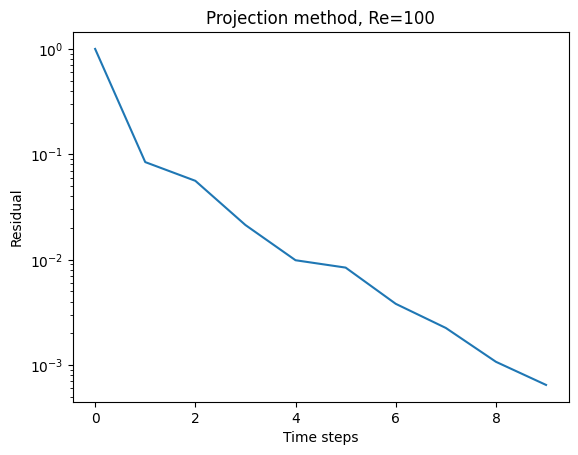

In [8]:
# Final residual        
print(f"Final Iteration = {itr}; Residual = {max_res}")
plt.plot(np.arange(itr), res_hist_classical)
plt.xlabel("Time steps")
plt.ylabel("Residual")
plt.title("Projection method, Re=100")
# plt.grid()
ax = plt.gca()
ax.set_yscale("log")

In [14]:
# Solve x here 
b = R/np.linalg.norm(R)
x = np.linalg.solve(L, b)
x_norm = np.linalg.norm(x)
x_normalized = x/np.linalg.norm(x)

### Encode into Hamiltonian

In [15]:
from qiskit.quantum_info.operators import Operator, SparsePauliOp
from qiskit.quantum_info import Pauli

N = 4        # number of qubits
dim = 2**N   # dimension of the operator 
b = b.reshape([dim, 1])
H_test = L.conj().T@(np.eye(dim)- b@b.T)@L
H = SparsePauliOp.from_operator(Operator(H_test))

## Preconditioning

### Jacobi

$$
M_{\text{Jacobi}}^{-1} = \text{diag}(A)^{-1}
$$

In [17]:
M = np.linalg.inv(np.diag(np.diag(L)))

# upper_diagonal = np.diagonal(L, offset=1)
# lower_diagonal = np.diagonal(L, offset=-1)
# M3 = np.linalg.inv(np.diag(np.diag(L)) + np.diag(upper_diagonal, k=1) + np.diag(lower_diagonal, k=-1))

L_new = M@L
b_new = M@b
b_new = b_new /np.linalg.norm(b_new)
H_jacobi = L_new.conj().T@(np.eye(dim)- b_new@b_new.T)@L_new
op_jacobi = SparsePauliOp.from_operator(Operator(H_jacobi))
print("Number of Pauli strings = ",len(op_jacobi))
print("Condition number = ", np.linalg.cond(L))
print("Condition number = ", np.linalg.cond(L_new))

Number of Pauli strings =  136
Condition number =  443.65862764187796
Condition number =  78.15719743270014


#### Incomplete LU

In [18]:
import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv('ilu4.csv', header=None)
M = df.values

L_new = M@L
b_new = M@b
b_new = b_new/np.linalg.norm(b_new)
H_ilu = L_new.conj().T@(np.eye(dim)- b_new@b_new.T)@L_new
op_ilu = SparsePauliOp.from_operator(Operator(H_ilu))
print("Number of Pauli strings = ",len(op_ilu))
print("Condition number = ", np.linalg.cond(L))
print("Condition number with preconditioning = ", np.linalg.cond(L_new))

Number of Pauli strings =  136
Condition number =  443.65862764187796
Condition number with preconditioning =  8.014510861758694


### Sparse approximate inverse (SPAI)

In [19]:
from scipy.sparse import identity
from scipy.sparse import diags
from scipy.sparse.linalg import onenormest

def spai(A, m):
    """Perform m step of the SPAI iteration."""
    n = A.shape[0]
    ident = identity(n, format='csr')
    alpha = 2 / onenormest(A @ A.T)
    M = alpha * A
        
    for index in range(m):
        C = A @ M
        G = ident - C
        AG = A @ G
        trace = (G.T @ AG).diagonal().sum()
        alpha = trace / np.linalg.norm(AG.data)**2
        M = M + alpha * G
        
    return M

In [20]:
M = spai(L, 10)
L_new = M@L
b_new = M@b
b_new = b_new /np.linalg.norm(b_new)
H_spai = L_new.conj().T@(np.eye(dim)- b_new@b_new.T)@L_new
op_spai = SparsePauliOp.from_operator(Operator(H_spai))
print("Number of Pauli strings = ",len(op_spai))
print("Condition number = ", np.linalg.cond(L))
print("Condition number = ", np.linalg.cond(L_new))

Number of Pauli strings =  136
Condition number =  443.65862764187796
Condition number =  31.92741902109611


### Multigrid

In [22]:
import warnings
warnings.filterwarnings("ignore")

In [23]:
from pyamg.aggregation import smoothed_aggregation_solver

ml = smoothed_aggregation_solver(L) 
op = ml.aspreconditioner(cycle='V')
M = op * np.identity(op.shape[1])
L_new = M@L
b_new = M@b
b_new = b_new/np.linalg.norm(b_new)
H_amg = L_new.conj().T@(np.eye(dim)- b_new@b_new.T)@L_new
op_amg = SparsePauliOp.from_operator(Operator(H_amg))
print("Number of Pauli strings = ",len(op_amg))
print("Condition number = ", np.linalg.cond(L))
print("Condition number with preconditioning = ", np.linalg.cond(L_new))

Number of Pauli strings =  136
Condition number =  443.65862764187796
Condition number with preconditioning =  1.1322462385523713


## VQE result

### Random initialization

In [47]:
import random
from qiskit import QuantumCircuit
from qiskit.circuit.library import TwoLocal,RealAmplitudes,EfficientSU2,NLocal,PauliTwoDesign,QAOAAnsatz
from qiskit.quantum_info import Statevector
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit_algorithms.minimum_eigensolvers import VQE, NumPyMinimumEigensolver
from qiskit_aer import AerSimulator
from qiskit_algorithms.optimizers import *
from qiskit.quantum_info import state_fidelity

random.seed(6)
for _ in range(10):
    print("================================================================================")
    seed = random.randint(0, 10000)
    print("Seed:", seed)
    rng = np.random.default_rng(seed)

    ### ============================= HEA =============================
    # ansatz = TwoLocal(N, ['rz','ry','rz'], 'cx', entanglement="linear", reps=5, skip_final_rotation_layer=False)

    ### ============================= RAA =============================
    ansatz = RealAmplitudes(N, entanglement="linear", reps=5, skip_final_rotation_layer=False)

    ### ============================= ALT =============================
    # layer1 = [(0, 1), (2, 3)]
    # layer2 = [(1, 2)]
    # ansatz = RealAmplitudes(N, reps=5, entanglement=[layer1 , layer2], skip_final_rotation_layer=False)
    
    ### ============================= TEN =============================
    # really bad ansatz
    # ansatz = RealAmplitudes(N, reps=5, entanglement=[(0, 1), (2, 3)], skip_final_rotation_layer=False)
    
    ### ============================= QAOA, HVA =============================
    # Not considered for now.

    ### ============================= Parameter initialization =============================
    ip = rng.uniform(-np.pi, np.pi, ansatz.num_parameters)
    # print("Initial parameters:", ip)

    ### ============================= Optimizer =============================
    itr = 20000
    # optimizer = L_BFGS_B(maxiter=itr)
    # optimizer = L_BFGS_B(maxfun=itr, maxiter=itr, iprint = 99)
    optimizer = L_BFGS_B(maxfun=itr, maxiter=itr)
#     optimier = GradientDescent()
    # optimizer = SPSA(maxiter=itr)
#     optimizer = AQGD(maxiter=itr)
    # optimizer = COBYLA(maxiter=itr, rhobeg=0.1, tol=1e-9)
    # optimizer = COBYLA(maxiter=itr)

    ### ============================= VQE =============================
    est = AerEstimator(run_options={"seed": 6, "shots": None}, approximation = True)
    # est = AerEstimator(run_options={"seed": 6, "shots": 1e4}, approximation = False)

    # Create the callback function to store intermediate values in vqe
    counts = []
    values = []
    parameters_list=[]
    std_list=[]
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
        parameters_list.append(parameters)
        std_list.append(std)
 
    vqe = VQE(est, ansatz, optimizer, initial_point=ip, callback=store_intermediate_result)
    result_sim = vqe.compute_minimum_eigenvalue(op_amg)    # switch to other preconditioned Hamiltonian
    eig_sim = result_sim.eigenvalue

    ### ============================= Error Analysis =============================
    fixed_params = result_sim.optimal_point
    opt_circ = result_sim.optimal_circuit.assign_parameters(fixed_params)
    opt_state = Statevector(opt_circ).data
    fid = state_fidelity(opt_state, x_normalized)
    print("State fidelity:", fid)
    print("Function evaluations = ", result_sim.cost_function_evals)
    
    if fid >0.99:
        break

Seed: 9401
State fidelity: 0.999999999670633
Function evaluations =  1100


In [48]:
# cost = values
# cost_jacobi = values
# cost_spai = values
# cost_ilu = values
cost_amg = values

Function evaluations: 1100


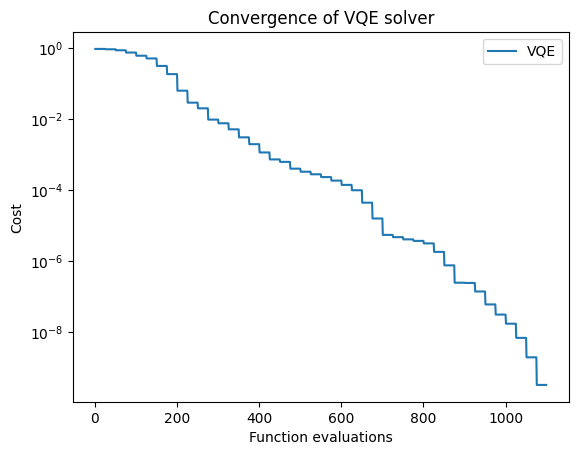

In [49]:
print("Function evaluations:", len(counts))
plt.semilogy(counts[0:-1], values[0:-1], '-',label="VQE")
plt.legend()
plt.xlabel("Function evaluations")
plt.ylabel("Cost")
plt.title("Convergence of VQE solver")
plt.show()

### Compare convergence rate

Text(0, 0.5, 'Cost')

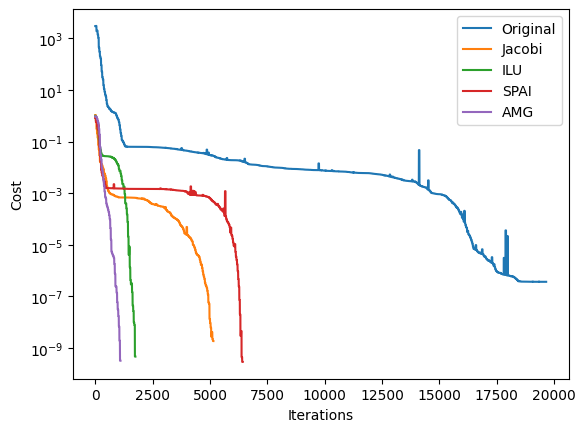

In [50]:
plt.semilogy(cost, label="Original")
plt.semilogy(cost_jacobi, label="Jacobi")
plt.semilogy(cost_ilu, label="ILU")
plt.semilogy(cost_spai, label="SPAI")
plt.semilogy(cost_amg, label="AMG")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Cost")

## Software info

In [51]:
import qiskit
import qiskit_ibm_runtime

print(f'Qiskit: {qiskit.__version__}')
print(f'Qiskit IBM Runtime: {qiskit_ibm_runtime.__version__}')

Qiskit: 1.0.2
Qiskit IBM Runtime: 0.23.0
